# [TPV3] Off fault case: Desktop at Uni
by JN Hayek (Created on 02.12.2020)


In [1]:
import os, sys, math, time

from glob import glob
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

sys.path.insert(0,"/import/freenas-m-03-geodynamics/jhayek/TEAR/processing/TEAR/PythonCodes/LibFolder")
from Lib_GeneralFunctions import *
from Lib_GeneralSignalProcNAnalysis import *
from Lib_ProfilePlotting import *
from Lib_ProfileProcessing import *

#=================== Plotting style ===================
plt.style.use('seaborn-whitegrid')

from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec

#definition of colormap
from palettable.scientific.sequential import Oleron_20
cmap = Oleron_20.mpl_colormap
plt.register_cmap(cmap=cmap)
plt.set_cmap('Oleron_20')

<Figure size 432x288 with 0 Axes>

In [2]:
# Timestamp variable
start_time = time.time()

In [3]:
# Save into a class the 
class TPV3reference:
    def __init__(self, filename, coordinates, RefSource="SEM2DPACK"):
        
        line = pd.read_csv(filename.format("slip"), header=None)
        self.Time = line[0]
        self.Slip = line[1]
        
        line = pd.read_csv(filename.format("sr"), header=None)
        self.SlipRate = line[1]
        
        self.Coord = coordinates #Only used for labels and 
        self.RefSource = RefSource
    #end __init__
    
    # Default object printing information
    def __repr__(self):
        return "The TPV3reference object was generated from: {} and the receiver is located at {}".format(self.RefSource, self.Coord)
    #end __repr__
    
    def __str__(self):
        return "The TPV3reference object was generated from: {} and the receiver is located at {}".format(self.RefSource, self.Coord)
    #end __str__
    
    def PlotReference(self, ax, SlipSlipRate, filtering=True, **kwargs):
        
        if SlipSlipRate=="Slip":
            if(filtering):
                ax.plot(self.Time, Butterworth(self.Slip, **kwargs), label = "", c = "k", ls = "--", zorder=1)
            else:
                ax.plot(self.Time, self.Slip, label = "", c = "k", ls = "--", zorder=1)
        elif SlipSlipRate=="SlipRate":
            if(filtering):
                ax.plot(self.Time, Butterworth(self.SlipRate, **kwargs), label = "", c = "k", ls = "--", zorder=1)
            else:
                ax.plot(self.Time, self.SlipRate, label = "", c = "k", ls = "--", zorder=1)
            
        return ax

In [4]:
path = "/import/freenas-m-03-geodynamics/jhayek/TEAR/processing/TEAR/ProfilePicking/"

# Reference saved into a list of objects
RefList = [TPV3reference(path + "Output/Reference/sem2dpack/sem2d-{}-2.txt", "4km"),
           TPV3reference(path + "Output/Reference/sem2dpack/sem2d-{}-3.txt", "6km"),
           TPV3reference(path + "Output/Reference/sem2dpack/sem2d-{}-4.txt", "8km"),
          ]

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


In [34]:
def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.set_xlim(0,7)
        ax.set_ylim(-1,1)
        
        
    Lines = fig.axes[-1].get_lines()[-4:]
    
    legend2 = fig.axes[-1].legend(Lines, ['Reference', '4km', '6km', '8km'], loc=1)
    fig.axes[-1].add_artist(legend2)

def GenericFigAxis():
    fig = plt.figure(constrained_layout=True, figsize=[12,4])
    gs = GridSpec(1, 2, figure=fig)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    
    
    return fig, [ax1, ax2]

In [35]:
def PlotReceiverFile(ax, ReceiverFile, ColIDX, OrderPeriodicity=8, NumReceivers=3, filtering=True, **kwargs):
    ylabeldict={1:"Slip (m)", 2:"Slip Rate (m)", 3:"$\mu$"}
    
    if(filtering):
        SamplingFrequency = 1./(ReceiverFile[0][1]-ReceiverFile[0][0])
        [ax.plot(ReceiverFile[0], 
                 Butterworth(ReceiverFile[ColIDX+OrderPeriodicity*i],SamplingFrequency = SamplingFrequency, **kwargs), 
                 zorder=2) for i in range(NumReceivers)]
    else:
        [ax.plot(ReceiverFile[0], ReceiverFile[ColIDX+OrderPeriodicity*i], zorder=2) for i in range(NumReceivers)]
        
    ax.set_ylabel(ylabeldict[ColIDX])
    ax.set_xlabel("time (s)")
    return ax

In [36]:
def PlotTimeProfileSetFlex(ax, Set,SlipSlipRate,title,Filtered = False, absolute = False, **kwargs):
    UnitsDict = {"Slip" : "Slip [m]", "SlipRate" : "Slip Rate [m/s]"}
    
    ax.set(xlabel = 'Time [s]', ylabel = UnitsDict[SlipSlipRate], 
           title = title)
    
    OrdinateVariableList=[]
    for idx,item in enumerate(Set):
        
        if (SlipSlipRate == "Slip"):
            OrdinateVariableList.append([a for a in item.DispX]) 
        elif (SlipSlipRate == "SlipRate"):
            OrdinateVariableList.append([a for a in item.VelX])

        if (Filtered):
            OrdinateVariableList[idx] = [a for a in Butterworth(OrdinateVariableList[idx])]

        if (absolute):
            OrdinateVariableList[idx] = [abs(a) for a in OrdinateVariableList[idx]]

    for idx,item in enumerate(Set):
        ax.plot(item.Time, OrdinateVariableList[idx], **kwargs)

def PlotFlexSpecificLegend(ax, ListOfFiles,SlipSlipRate,title,Filtered=True,**kwargs):
    for iidx,SingleFile in enumerate(ListOfFiles):
        head, tail = os.path.split(SingleFile)
        File = LoadPickleFile(Filename = tail,FolderPath = head+"/")
        PlotTimeProfileSetFlex(ax, File, SlipSlipRate, title,Filtered,
                               zorder = iidx + 2, c = cmap(iidx/(len(ListOfFiles)+1)),
                               **kwargs )    

    return ax

In [37]:
CompletePath = [path+r"[TPV3]Results/20201202Duo/300dx-1p-300.3delta/TPList_t280_d300.1.pickle"]

<AxesSubplot:title={'center':'Direct'}, xlabel='Time [s]', ylabel='Slip Rate [m/s]'>

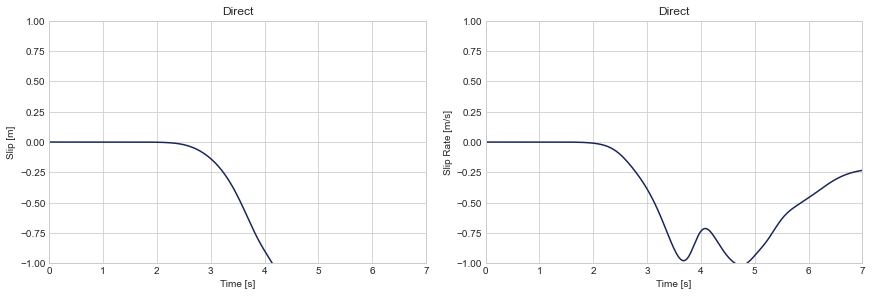

In [38]:
fig,axis=GenericFigAxis()
format_axes(fig)

PlotType = "Slip"
#[item.PlotReference(axis[0], PlotType, filtering=True) for item in RefList] #Reference
PlotFlexSpecificLegend(axis[0], CompletePath, "Slip", "Direct")

PlotType = "SlipRate"
#[item.PlotReference(axis[1], PlotType, filtering=True) for item in RefList] #Reference
PlotFlexSpecificLegend(axis[1], CompletePath,"SlipRate","Direct")

In [39]:

head, tail = os.path.split(CompletePath[0])
File = LoadPickleFile(Filename = tail,FolderPath = head+"/")
aaa = File[0]

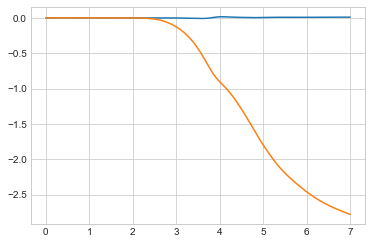

In [40]:
plt.plot(aaa.Time,aaa.DispY)
plt.plot(aaa.Time,aaa.DispX)

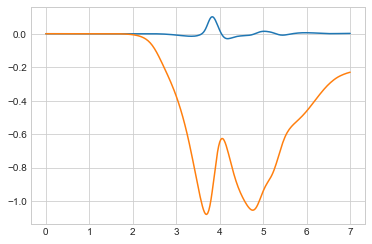

In [42]:
plt.plot(aaa.Time,aaa.VelY)
plt.plot(aaa.Time,aaa.VelX)